In [74]:
%matplotlib inline 

import numpy as np
import pandas as pd
from scipy.stats import pearsonr 
import matplotlib.pyplot as plt
import glob
import os
import time
import xarray as xr

# import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

import seaborn as sns
sns.set_style('white')
sns.set_context("poster") #[poster, paper, talk, notebook]

import matplotlib.patheffects as PathEffects

from windrose import WindroseAxes
import matplotlib.cm as cm

<xarray.Dataset>
Dimensions:  (time: 3, x: 1000, y: 1000)
Coordinates:
  * x        (x) float32 279207.0 279210.0 279213.0 ... 282201.0 282204.0
  * y        (y) float32 4221327.0 4221324.0 4221321.0 ... 4218333.0 4218330.0
  * time     (time) datetime64[ns] 2015-03-06 2016-04-16 2017-04-01
    mask     (y, x) uint8 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 600), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 600), meta=np.ndarray>


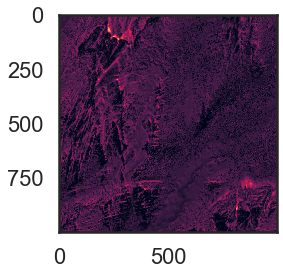

In [75]:
# fname = '~/Documents/projects/thesis/results/output/compiled_SUPERsnow.nc' #ARS
fname = '~/Documents/research/sierra/data/compiled_SUPERsnow.nc' #BSU
# fname = '~/Documents/research/sierra/data/20m_analysis/compiled_SUPERsnow_20m.nc' #BSU
#~~~~ ds full
ds = xr.open_dataset(fname,  chunks={'time':1,'x':1000,'y':1000})
ds.close()
# #~~~~ ds peak
dpeak = ds.isel(time=[0,7,18,30,42,49]) 
dpeak.close()
ds = dpeak
ds.close()
#~~~convert to cm
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
#grab 2015, 2016, 2017 nearest peak SWE
ds=ds.isel(time=slice(2,5))
ds.close()
#northern slice of data
d = ds.isel(x=slice(8400,9400), y=slice(3000,4000))
d.close()
#~~~convert to ints again
d=d.astype(np.int16, copy=False)
print(d)
plt.imshow(d.snow.isel(time=1))

#dataset is d here! 1km by 1km area in northern Tuolumne (2 valleys west of slide canyon)

<function matplotlib.pyplot.show(*args, **kw)>

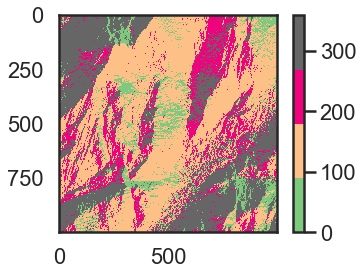

In [76]:
# path = '/home/meganmason/Documents/projects/thesis/data/processing_lidar/depths_3m/equal_extent/terrain/*.nc' #ARS
path = '/Users/meganmason491/Documents/research/sierra/data/terrain/*.nc' #BSU
fpath = glob.glob(path)

terrain=xr.open_mfdataset(fpath, concat_dim=None, combine='nested', chunks={'x':1000, 'y':1000}, parallel=True).rename({'Band1':'hillshade'}).drop('transverse_mercator') #combine='nested', 

terrain=np.flip(terrain.aspect,0) #terrain needs to be flipped!
terrain=terrain.where(ds.mask==1)
terrain=terrain.to_dataset()
terrain.close()

terr = terrain.isel(x=slice(8400,9400), y=slice(3000,4000))
cmap = plt.cm.get_cmap('Accent', 4)
plt.imshow(terr.aspect, cmap=cmap)
plt.colorbar()
plt.show

#use terr for the smaller piece to match d (dataset)

## standardized

In [77]:
# compute stats from xarray dataset
x_gt0 = d.snow.where(d.snow>0) #snow depths greater than zero
mu_gt0 = x_gt0.mean(dim=('x', 'y'))
sig_gt0 = x_gt0.std(dim=('x', 'y'))

#standardize
stdize = ((x_gt0 - mu_gt0) / sig_gt0)
# print('\nSTDIZE', stdize)

## flatten

In [78]:
s_flat_15 = stdize.isel(time=0).values.flatten() #switch time: 0, 1, 2
s_flat_16 = stdize.isel(time=1).values.flatten() #switch time: 0, 1, 2
s_flat_17 = stdize.isel(time=2).values.flatten() #switch time: 0, 1, 2

In [79]:
#flatten values between 0 and 2
s_flat_15 = np.where(s_flat_15>=0, s_flat_15, np.nan)
s_flat_15 = np.where(s_flat_15<=2, s_flat_15, np.nan)

s_flat_16 = np.where(s_flat_16>=0, s_flat_16, np.nan)
s_flat_16 = np.where(s_flat_16<=2, s_flat_16, np.nan)

s_flat_17 = np.where(s_flat_17>=0, s_flat_17, np.nan)
s_flat_17 = np.where(s_flat_17<=2, s_flat_17, np.nan)


//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less_equal
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater_equal
  
//anaconda3/envs/data_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


In [80]:
a_flat = terr.aspect.values.flatten() #aspect

## rose diagram

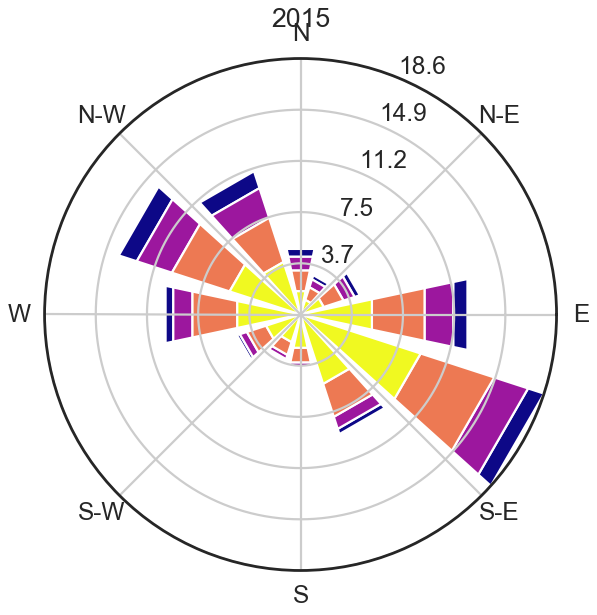

In [88]:
ax = WindroseAxes.from_ax()
ax.bar(a_flat[~np.isnan(s_flat_15)], s_flat_15[~np.isnan(s_flat_15)], nsector=12, normed=True, bins=np.arange(0, 2, .5), cmap=cm.plasma_r) #normed=True,
# ax.set_legend(fontsize=28)
ax.set_title('2015')
plt.savefig('../figs/rose_sub_15', dpi=300, transparent=True)
plt.show()

#percentage of total occupied by each

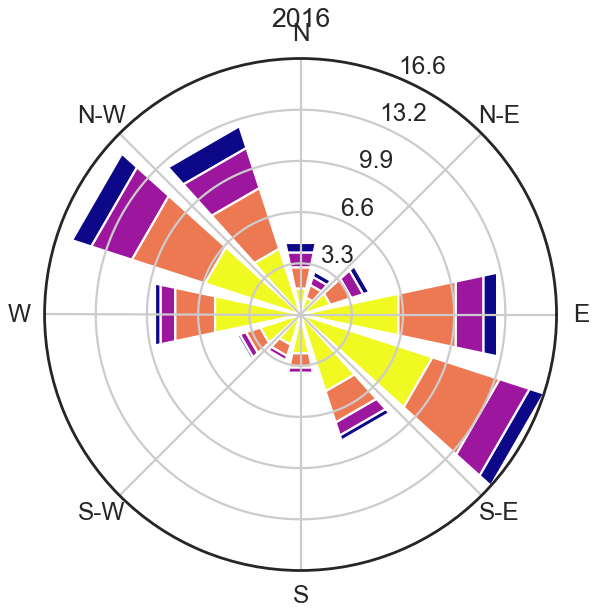

In [82]:
ax = WindroseAxes.from_ax()
ax.bar(a_flat[~np.isnan(s_flat_16)], s_flat_16[~np.isnan(s_flat_16)], nsector=12, normed=True, bins=np.arange(0, 2, .5), cmap=cm.plasma_r) #normed=True,
# ax.set_legend(fontsize=28)
ax.set_title('2016')
plt.savefig('../figs/rose_sub_16', dpi=300, transparent=True)
plt.show()

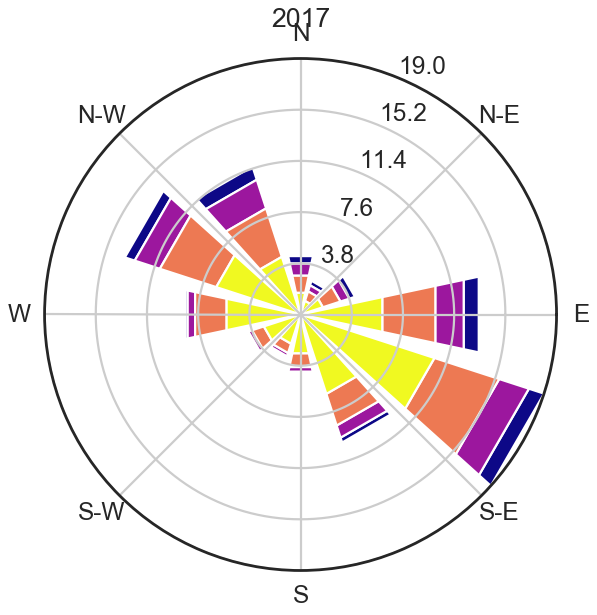

In [83]:
ax = WindroseAxes.from_ax()
ax.bar(a_flat[~np.isnan(s_flat_17)], s_flat_17[~np.isnan(s_flat_17)], nsector=12, normed=True, bins=np.arange(0, 2, .5), cmap=cm.plasma_r) #normed=True,
# ax.set_legend(fontsize=28)
ax.set_title('2017')
plt.savefig('../figs/rose_sub_17', dpi=300, transparent=True)
plt.show()

In [84]:
## quick check on whole basin

In [85]:
# d_big_flat = ds.snow.isel(time=0)[::1000].values.flatten()
# len(d_big_flat)

In [86]:
# aspect_flat = terrain.aspect[::1000].values.flatten()
# len(aspect_flat)

In [87]:
# ax = WindroseAxes.from_ax()
# ax.bar(aspect_flat, ~np.isnan(d_big_flat), normed=True, bins=np.arange(-3, 3, 1))
# ax.set_legend()
# plt.show()